In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv


# Importing libraries


In [2]:
#importing libraries
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, accuracy_score,
    recall_score, precision_score
)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

# Preparing dataset and features

In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv")
df.dropna(inplace=True)

In [4]:
#creating new features
df["smokingActivity"] = df["cigsPerDay"] * df["currentSmoker"]
df["diaBPsysBP"] = df["diaBP"] * df["sysBP"]

In [5]:
# Define features and target
features = ["male", "age", "BPMeds", "prevalentStroke",
            "prevalentHyp", "diabetes", "totChol", "glucose",
            "smokingActivity", "diaBPsysBP"]
target = df["TenYearCHD"]

X = df[features]
y = target

# Visualizing data

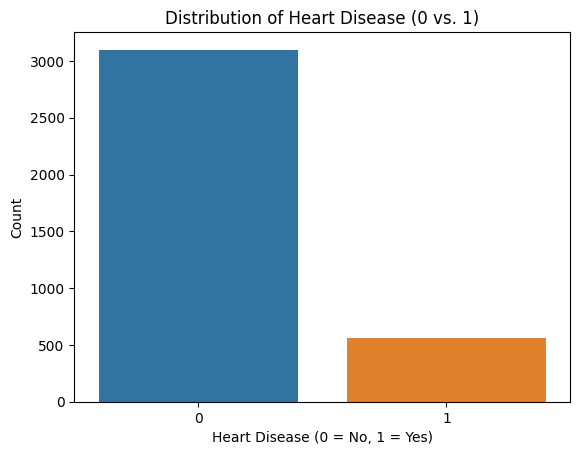

In [6]:
#visualizing class imbalance 
count_values = target.value_counts()

sns.barplot(x=count_values.index, y=count_values.values)
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Distribution of Heart Disease (0 vs. 1)')
plt.show()

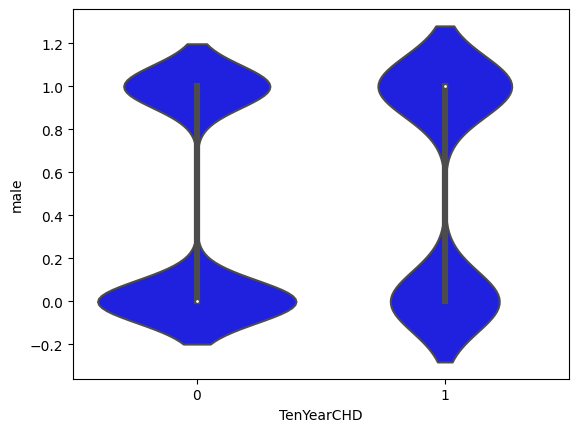

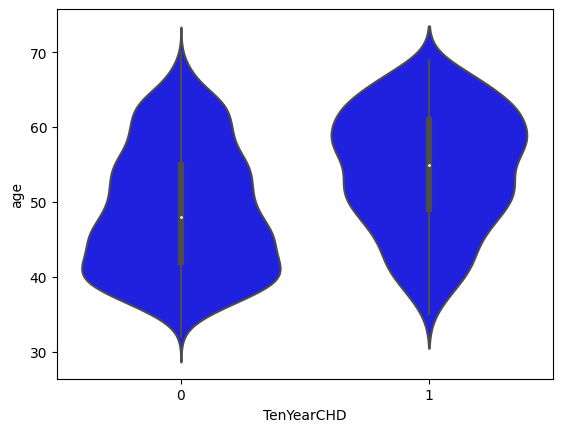

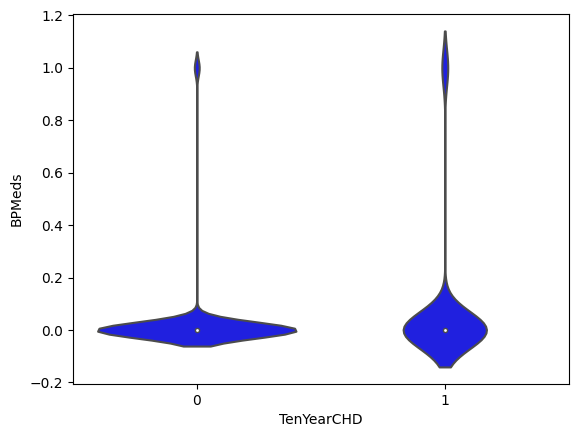

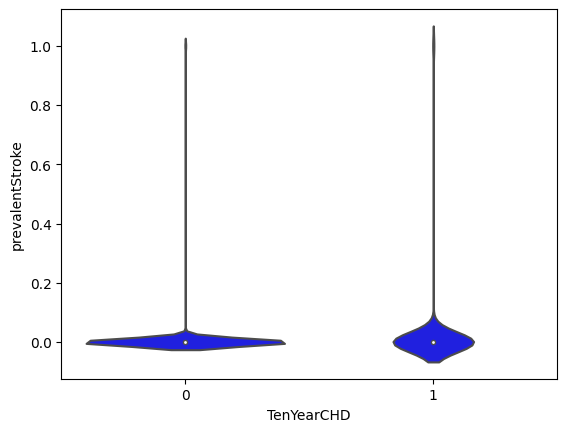

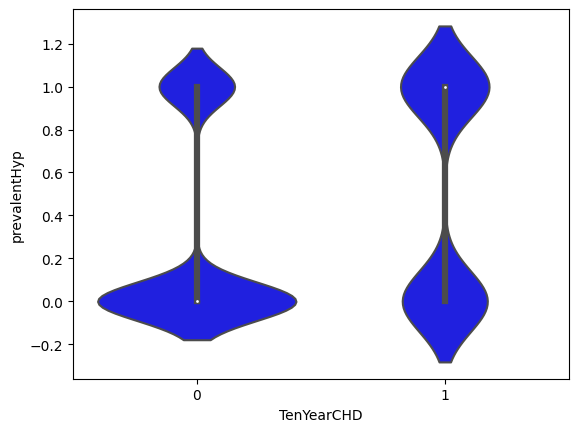

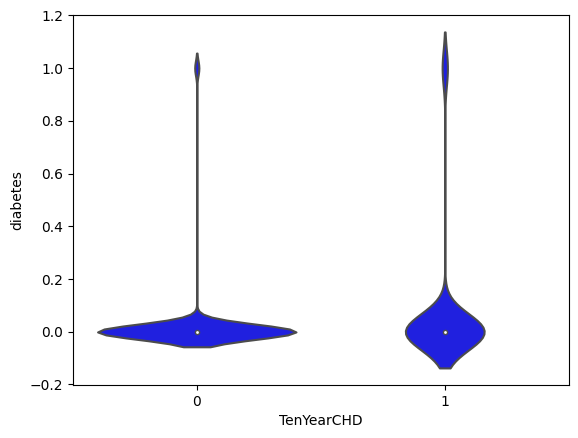

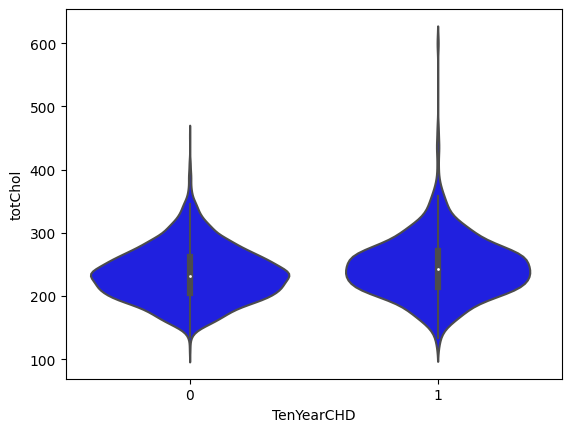

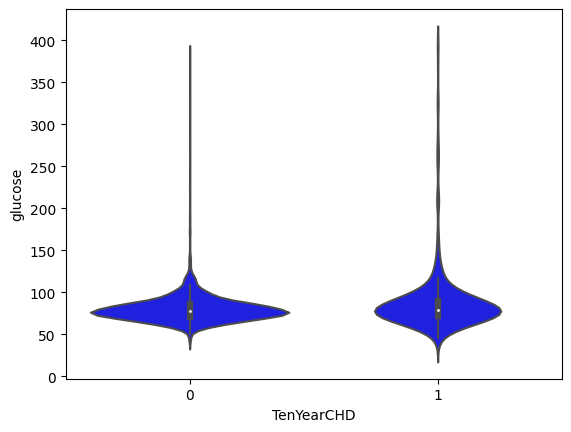

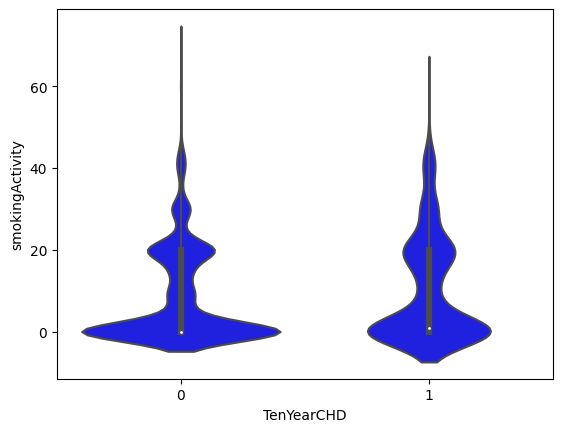

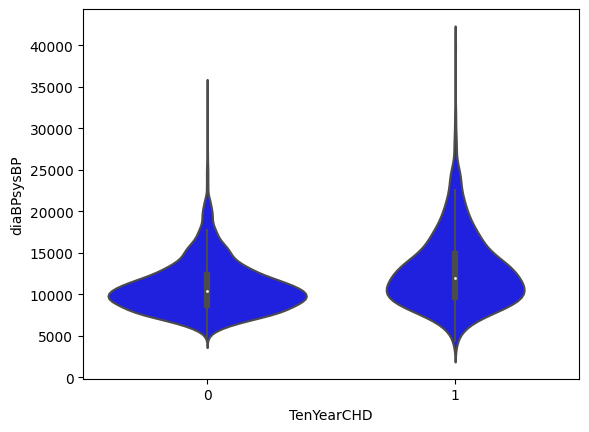

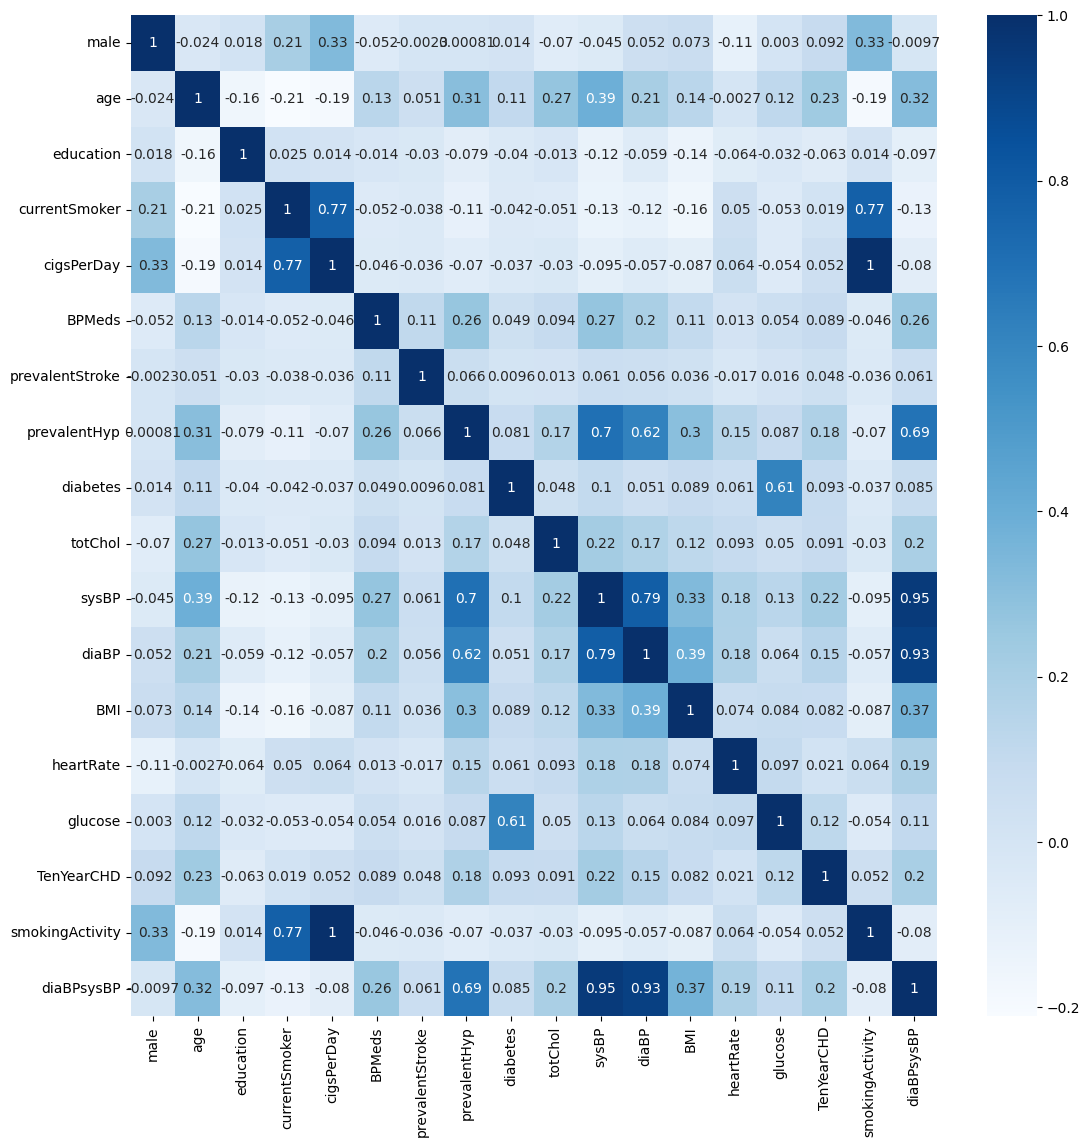

In [7]:
# Visualize data distributions and correlations
for feature in features:
    sns.violinplot(x=target, y=df[feature], color="blue")
    plt.show()

plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), annot=True, cmap="Blues")
plt.show()

# Making model

In [8]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features),
    ]
)

In [9]:
# Creating an imbalanced pipeline with SMOTE
smote = SMOTE(random_state=42)

pipeline = imPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]
)

In [10]:
# Hyperparameter grid
param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["newton-cg", "lbfgs", "sag", "liblinear"],
    "classifier__penalty": ["l2"],
    "classifier__max_iter": [10000]
}

In [11]:
# Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search on the entire dataset
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf)
grid_search.fit(X, y)

# Get the best model and hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_}")

# Use the best model for evaluation
best_model = grid_search.best_estimator_

Best hyperparameters: {'classifier__C': 0.1, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Best ROC AUC score: 0.6739629820666353


In [12]:
# Lists to store metrics
accuracies = []
roc_aucs = []
threshold = 0.5

In [13]:
# Cross-validation with the best model
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    best_model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred)

    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)

    # Print metrics for each fold
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:0.2f}")
    print(f"ROC AUC: {roc_auc:0.2f}")
    print(f"Precision: {precision:0.2f}")
    print(f"Recall: {recall:0.2f}")
    print("-" * 50)

Confusion Matrix:
[[411 199]
 [ 46  76]]
Accuracy: 0.67
ROC AUC: 0.70
Precision: 0.28
Recall: 0.62
--------------------------------------------------
Confusion Matrix:
[[425 199]
 [ 38  69]]
Accuracy: 0.68
ROC AUC: 0.75
Precision: 0.26
Recall: 0.64
--------------------------------------------------
Confusion Matrix:
[[400 217]
 [ 35  79]]
Accuracy: 0.66
ROC AUC: 0.72
Precision: 0.27
Recall: 0.69
--------------------------------------------------
Confusion Matrix:
[[435 186]
 [ 32  78]]
Accuracy: 0.70
ROC AUC: 0.76
Precision: 0.30
Recall: 0.71
--------------------------------------------------
Confusion Matrix:
[[423 204]
 [ 36  68]]
Accuracy: 0.67
ROC AUC: 0.71
Precision: 0.25
Recall: 0.65
--------------------------------------------------


# Results

In [14]:
# Average results
average_roc_auc = np.mean(roc_aucs)
average_accuracy = np.mean(accuracies)
print(f"Average ROC AUC: {average_roc_auc:0.2f}")
print(f"Average Accuracy: {average_accuracy:0.2f}")

Average ROC AUC: 0.73
Average Accuracy: 0.67
